In [27]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [28]:
asian_df_path = "~/ASR-PM2.5/datasets/intermediate_datasets/resultforasiandataset.csv"
asian_df = pd.read_csv(asian_df_path, dtype = {"FIPS": str}, index_col=0)

In [29]:
pm_df_path = "~/ASR-PM2.5/datasets/intermediate_datasets/resultforpm2.5dataset.csv"
pm_df = pd.read_csv(pm_df_path, dtype = {"FIPS": str}, index_col=0)

In [30]:
mean_pm_level = pm_df["pred_wght"].mean()
mean_pm_level

7.1754017072227825

In [31]:
combined_large_data = asian_df.merge(pm_df, on = "FIPS")

In [32]:
combined_large_data
combined_large_data["estimated_pop"].sum()

37902083

In [33]:
combined_large_data["relative_weight"] = combined_large_data["estimated_pop"] * combined_large_data["pred_wght"]

In [34]:
combined_large_data["weighted_average"] = ""

In [35]:
combined_large_data

,FIPS,POPGROUP,POPGROUP_LABEL,estimated_pop,pred_wght,relative_weight,weighted_average
0,06081,26,Pakistani alone,1017,8.628688,8775.375384,
1,06081,47,Thai alone in any combination,1116,8.628688,9629.615465,
2,06081,32,Asian Indian alone in any combination,18235,8.628688,157344.120083,
3,06081,16,Chinese alone,76964,8.628688,664098.319608,
4,06081,40,Indonesian alone in any combination,944,8.628688,8145.481182,
...,...,...,...,...,...,...,...
5371,22101,29,Vietnamese alone,600,7.413572,4448.143300,
5372,22101,48,Vietnamese alone in any combination,691,7.413572,5122.778367,
5373,22045,43,Laotian alone in any combination,990,8.107645,8026.568518,
5374,48057,35,Chinese alone in any combination,454,8.311283,3773.322515,


In [36]:
sorted_large_df = combined_large_data.sort_values("POPGROUP")

In [37]:
sorted_large_df["POPGROUP"]

3224    13
3572    13
2799    13
626     13
4670    13
        ..
2321    84
2870    84
2646    84
3267    84
1002    84
Name: POPGROUP, Length: 5376, dtype: int64

In [38]:
# shifts the popgroup down by 1 creating a list that increments by 1 for each popgroup after running the cumsum of ne

separate_subgroups = [value for index,value in sorted_large_df.groupby(sorted_large_df["POPGROUP"].ne(sorted_large_df["POPGROUP"].shift()).cumsum())]

In [39]:
separate_subgroups[0]

,FIPS,POPGROUP,POPGROUP_LABEL,estimated_pop,pred_wght,relative_weight,weighted_average
3224,13151,13,Asian Indian alone,2788,8.648723,24112.638746,
3572,13021,13,Asian Indian alone,1068,8.798820,9397.140237,
2799,36103,13,Asian Indian alone,16741,7.764497,129985.444170,
626,18003,13,Asian Indian alone,2266,10.129345,22953.095799,
4670,36055,13,Asian Indian alone,6210,8.250441,51235.239239,
...,...,...,...,...,...,...,...
1287,51087,13,Asian Indian alone,11335,7.737872,87708.776918,
2682,08001,13,Asian Indian alone,1403,6.601246,9261.548440,
5072,36111,13,Asian Indian alone,834,6.334383,5282.875425,
2039,13135,13,Asian Indian alone,20734,8.353870,173209.136225,


In [40]:
separate_subgroups

pre_calculation_datasets = separate_subgroups.copy()
pre_calculation_datasets.append(combined_large_data)


In [41]:
def calculations(dfs):
    def calculate_weighted_average(df):
        # calculate weighted average
        def is_unique(series):
            np_s = series.to_numpy()
            return np.all(np_s[0] == np_s)
        popgroups = df["POPGROUP"]
        popgroup_labels = df["POPGROUP_LABEL"]
        popgroup_num = popgroups.iloc[0] if is_unique(popgroups) else 0
        popgroup_label = popgroup_labels.iloc[0] if is_unique(popgroup_labels) else "Combined Asian American Subgroups"
        df.loc[df.shape[0]] = [None, popgroup_num, popgroup_label, df["estimated_pop"].sum(), None, df["relative_weight"].sum(), df["relative_weight"].sum() / df["estimated_pop"].sum()]
        # convert back to an int from float
        df.estimated_pop = df.estimated_pop.astype(int)
        df.POPGROUP = df.POPGROUP.astype(int)
    def calculate_std_dev(df):
        df["std_dev_parts_and_actual"] = ((df["pred_wght"] - df["weighted_average"].iloc[(len(df["weighted_average"]) - 1)]) ** 2) * df["estimated_pop"]
        df["std_dev_parts_and_actual"] = df["std_dev_parts_and_actual"].fillna(np.sqrt(df["std_dev_parts_and_actual"].sum() / df["estimated_pop"].iloc[(len(df) - 1)]))
    for df in dfs:
        calculate_weighted_average(df)
        calculate_std_dev(df)
    
    return dfs

In [42]:
final_separated_datasets = calculations(pre_calculation_datasets)
final_separated_datasets[0]

,FIPS,POPGROUP,POPGROUP_LABEL,estimated_pop,pred_wght,relative_weight,weighted_average,std_dev_parts_and_actual
3224,13151,13,Asian Indian alone,2788,8.648723,2.411264e+04,,0.378452
3572,13021,13,Asian Indian alone,1068,8.79882,9.397140e+03,,20.470940
2799,36103,13,Asian Indian alone,16741,7.764497,1.299854e+05,,13436.239190
626,18003,13,Asian Indian alone,2266,10.129345,2.295310e+04,,4889.749736
4670,36055,13,Asian Indian alone,6210,8.250441,5.123524e+04,,1043.556971
...,...,...,...,...,...,...,...,...
2682,08001,13,Asian Indian alone,1403,6.601246,9.261548e+03,,5948.727467
5072,36111,13,Asian Indian alone,834,6.334383,5.282875e+03,,4512.133452
2039,13135,13,Asian Indian alone,20734,8.35387,1.732091e+05,,1947.846220
5064,41003,13,Asian Indian alone,763,6.738373,5.141378e+03,,2818.588842


In [43]:
final_separated_datasets[42]

,FIPS,POPGROUP,POPGROUP_LABEL,estimated_pop,pred_wght,relative_weight,weighted_average,std_dev_parts_and_actual
0,06081,26,Pakistani alone,1017,8.628688,8.775375e+03,,0.033684
1,06081,47,Thai alone in any combination,1116,8.628688,9.629615e+03,,0.036963
2,06081,32,Asian Indian alone in any combination,18235,8.628688,1.573441e+05,,0.603962
3,06081,16,Chinese alone,76964,8.628688,6.640983e+05,,2.549125
4,06081,40,Indonesian alone in any combination,944,8.628688,8.145481e+03,,0.031266
...,...,...,...,...,...,...,...,...
5372,22101,48,Vietnamese alone in any combination,691,7.413572,5.122778e+03,,1029.952810
5373,22045,43,Laotian alone in any combination,990,8.107645,8.026569e+03,,274.740774
5374,48057,35,Chinese alone in any combination,454,8.311283,3.773323e+03,,47.412216
5375,55101,32,Asian Indian alone in any combination,754,8.30557,6.262400e+03,,81.550553


In [44]:
len(final_separated_datasets)

43

In [45]:
output_path = "~/ASR-PM2.5/datasets/output_datasets"

for dataset in final_separated_datasets:
    filepath = os.path.join(output_path, 'dataset_'+str(dataset["POPGROUP"].iloc[(len(dataset["POPGROUP"]) - 1)])+'.csv')
    dataset.to_csv(filepath)

In [46]:
num_fips = len(dict(zip(sorted_large_df.pred_wght, sorted_large_df.FIPS)))
num_fips

540

In [47]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..")
from helpers import invalid_fips, remove_cols

weighted_avg_rows = []
for df in final_separated_datasets:
    weighted_avg_rows.append(df.tail(1))

weighted_avg_df = pd.concat(weighted_avg_rows)
remove_cols(weighted_avg_df, ["POPGROUP_LABEL", "weighted_average", "std_dev_parts_and_actual"])

sorted_weighted_avg_df = weighted_avg_df.sort_values("weighted_average")

sorted_weighted_avg_df

,POPGROUP_LABEL,weighted_average,std_dev_parts_and_actual
2,Bhutanese alone,8.396463,0.674248
76,Thai alone in any combination,8.407654,1.546940
73,Cambodian alone in any combination,8.414457,1.714336
40,Burmese alone,8.428982,1.276327
65,Cambodian alone,8.433241,1.721843
211,Japanese alone in any combination,8.444615,1.541062
42,Burmese alone in any combination,8.479116,1.266976
383,Filipino alone in any combination,8.506586,1.479133
73,Laotian alone in any combination,8.507551,1.712357
262,Vietnamese alone in any combination,8.516586,1.313047


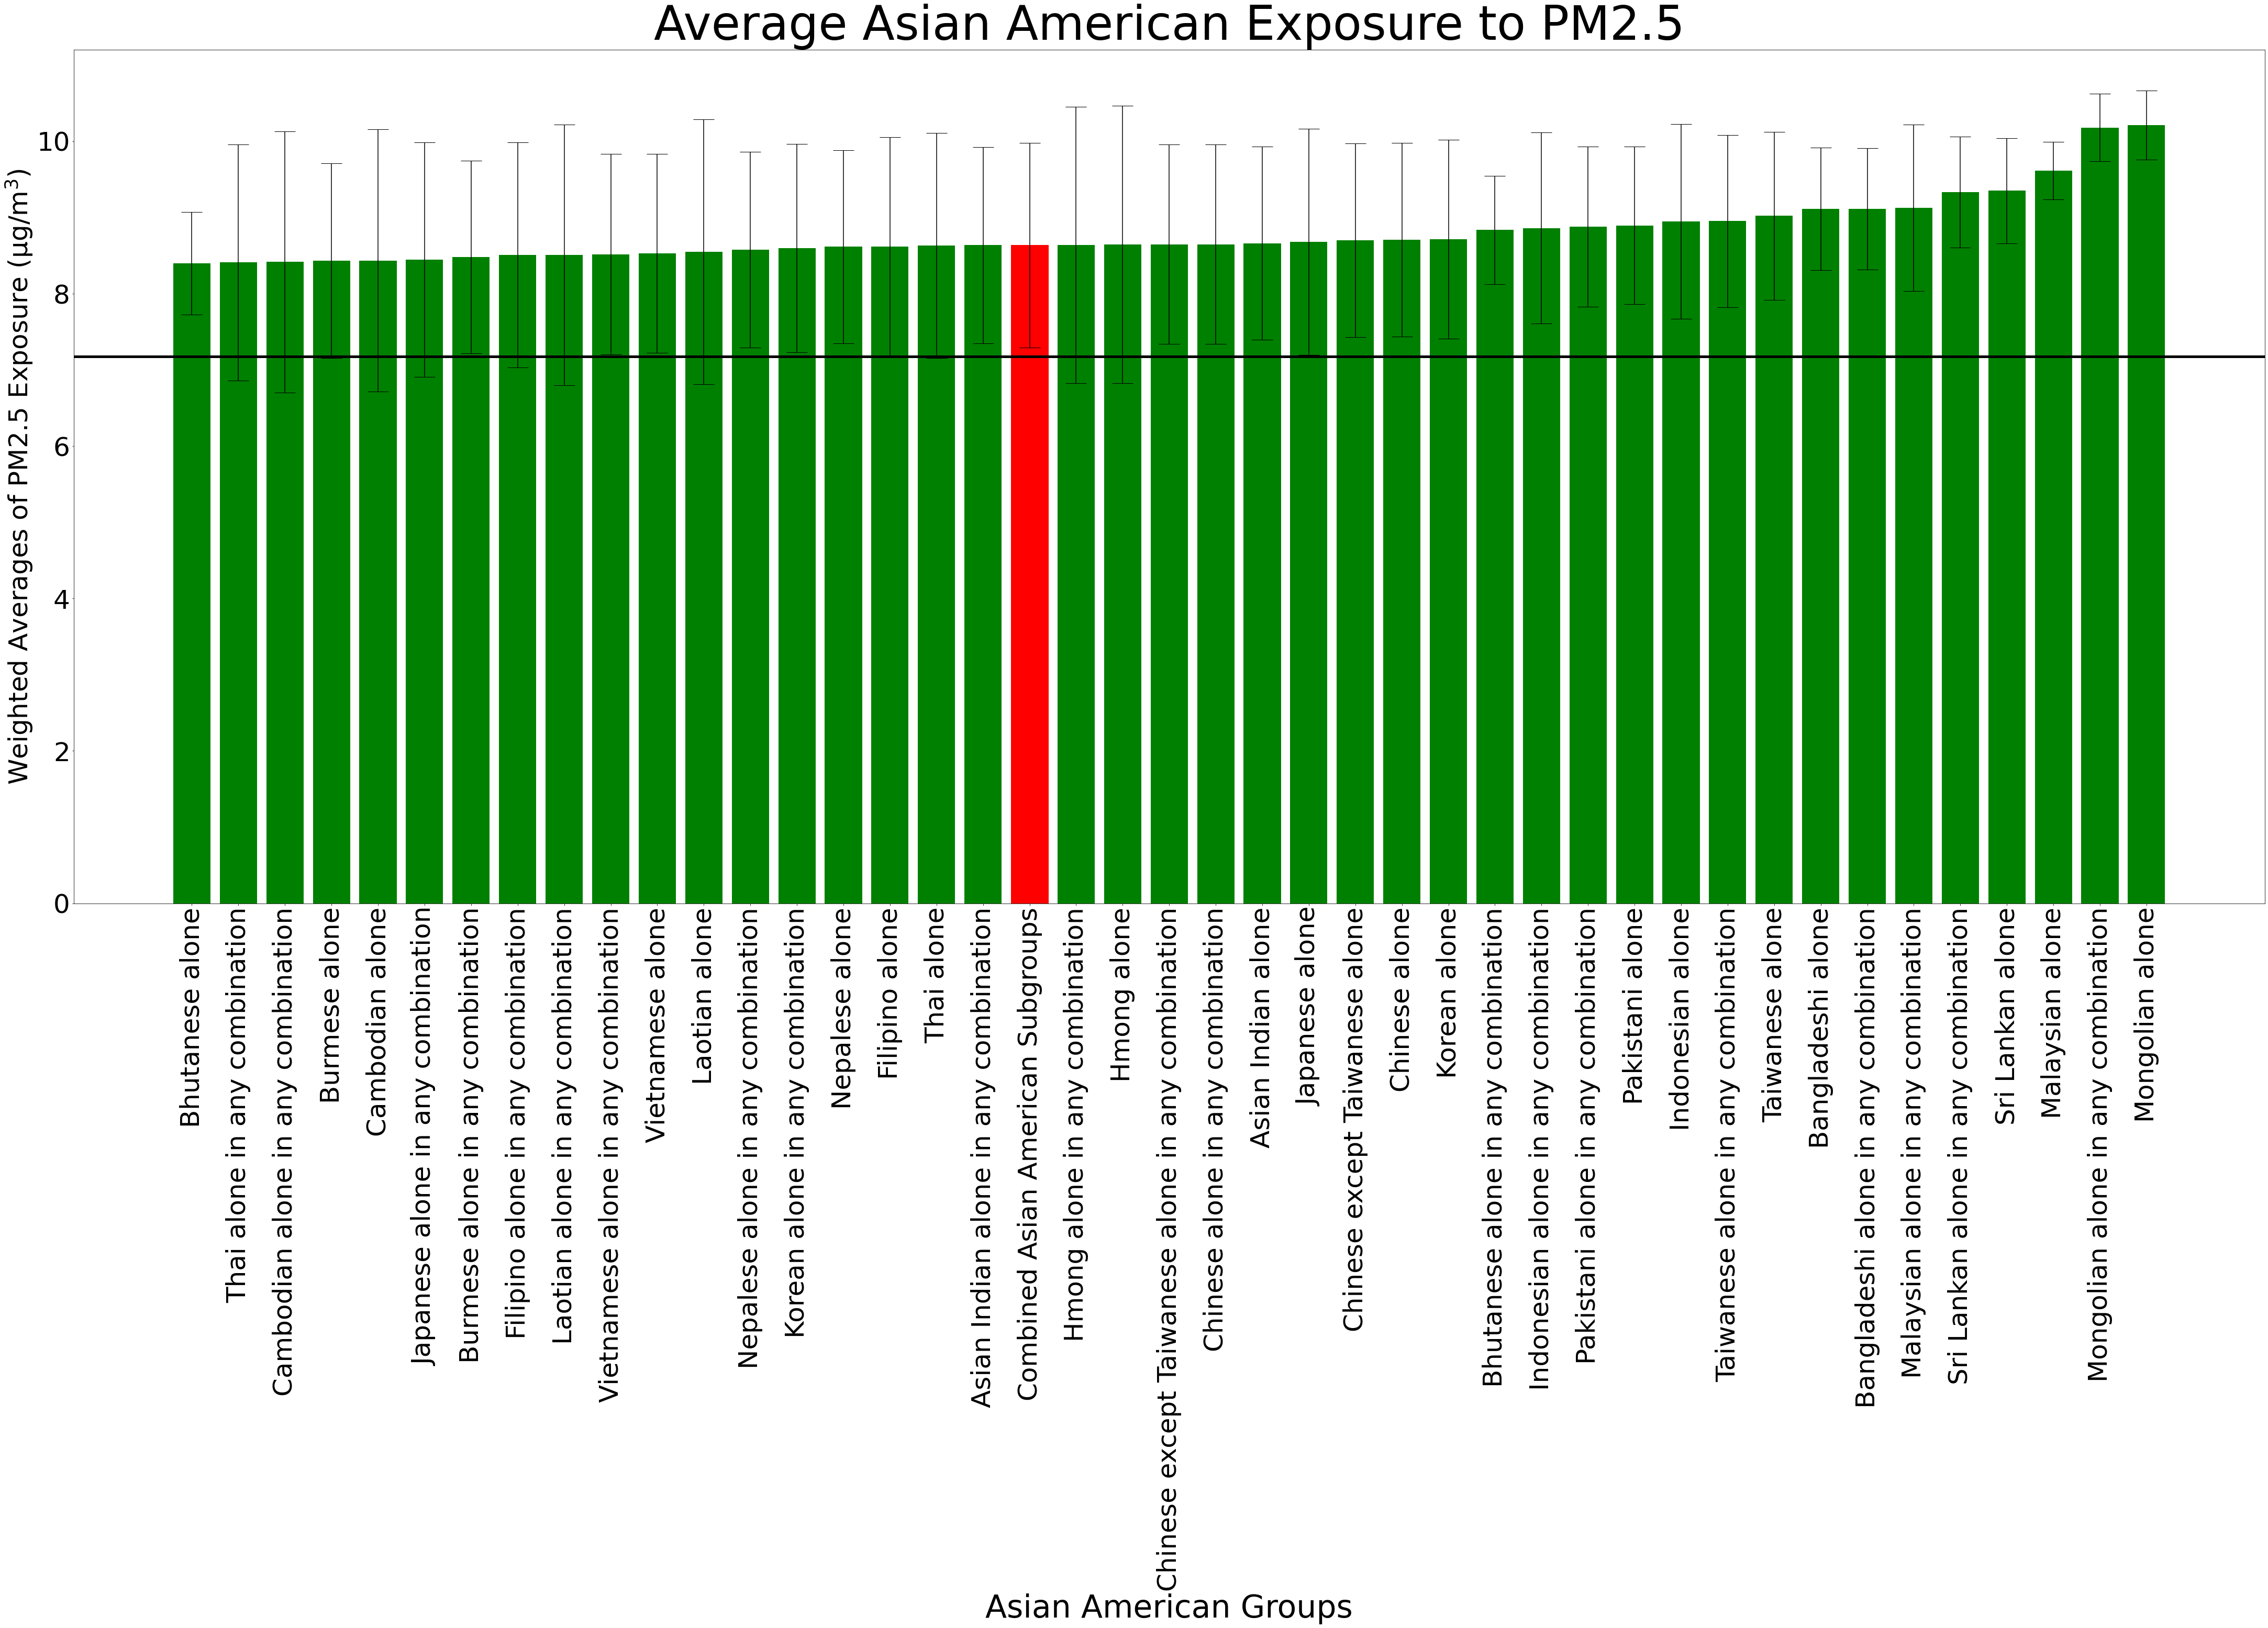

In [48]:
# Build the plot in general
popgroup_names = sorted_weighted_avg_df["POPGROUP_LABEL"].to_numpy()
weighted_avgs = sorted_weighted_avg_df["weighted_average"].to_numpy()
std_devs = sorted_weighted_avg_df["std_dev_parts_and_actual"].to_numpy()

x_pos = [i for i, _ in enumerate(popgroup_names)]


plt.figure(figsize=(75,30))
barlist = plt.bar(x_pos, weighted_avgs, color = "green", yerr = std_devs, capsize = 20)
barlist[18].set_color("red") # calling on index 18 to highlight average of all Asian Americans
plt.ylabel("Weighted Averages of PM2.5 Exposure (μg/m$^3$)", fontsize = 50)
plt.yticks(fontsize = 50)
plt.xlabel("Asian American Groups", fontsize = 60)
plt.title("Average Asian American Exposure to PM2.5", fontsize = 90)

plt.xticks(x_pos, popgroup_names, rotation = 90, fontsize = 50)

plt.axhline(y = mean_pm_level, linewidth = 5, color = "black")

plt.show()

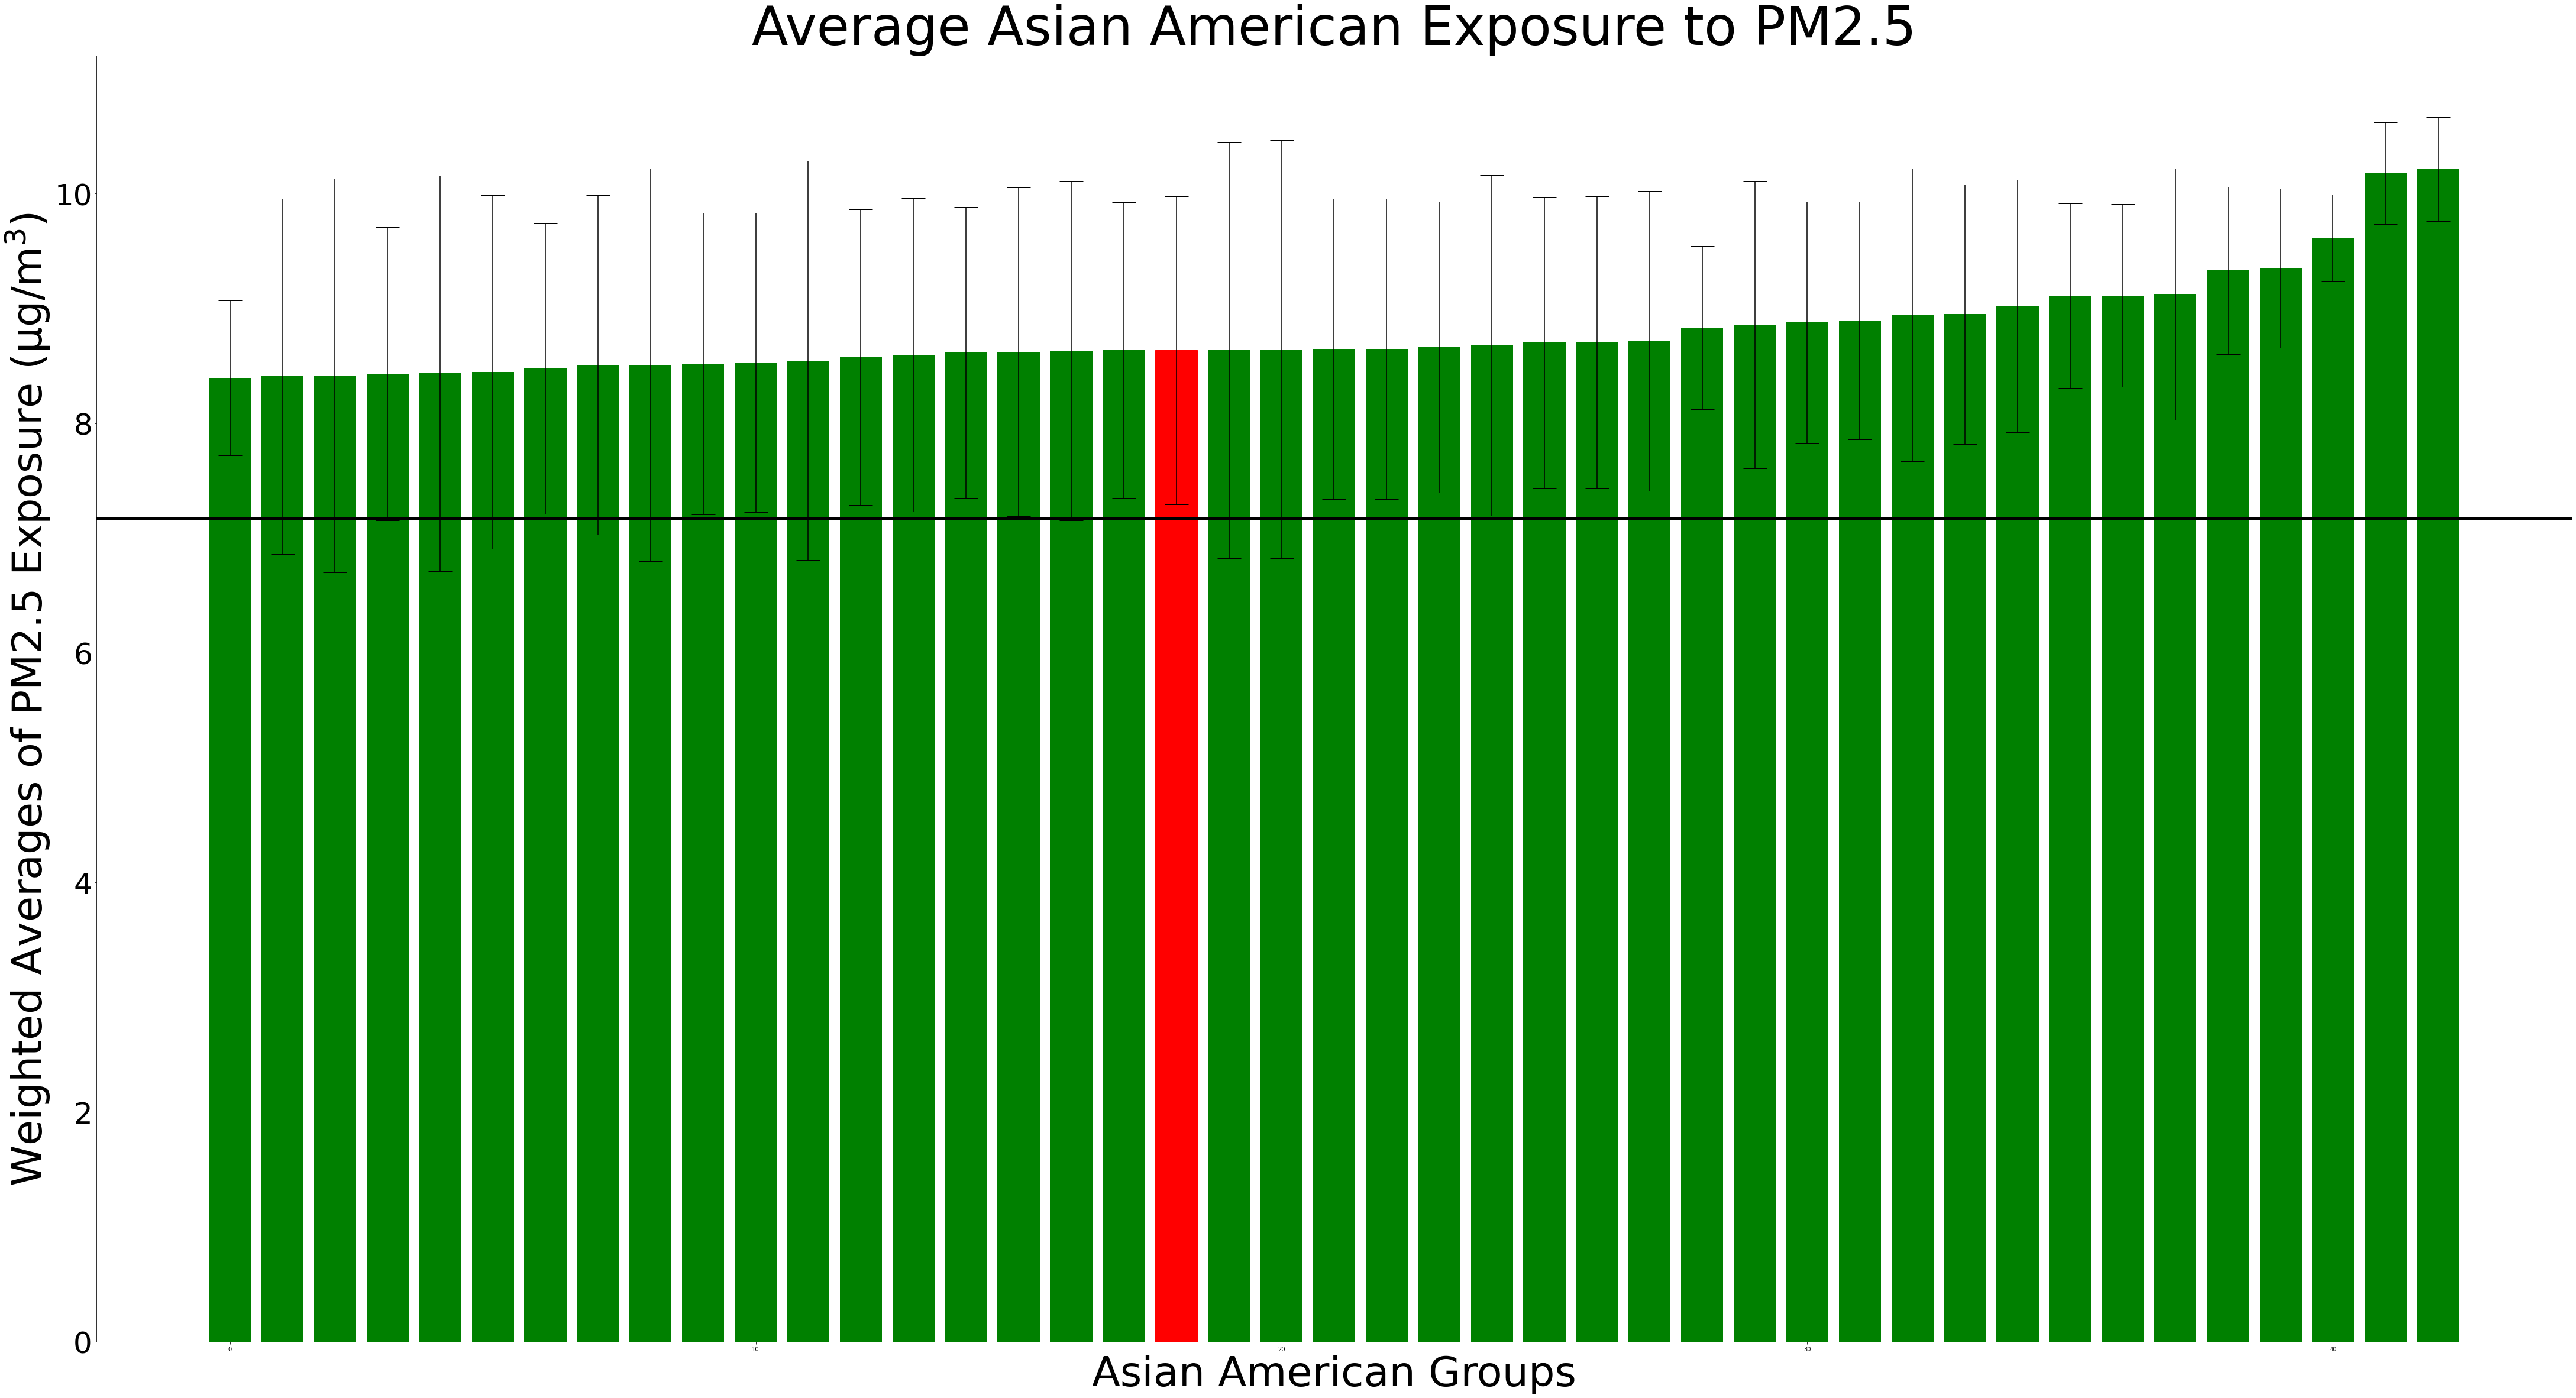

In [49]:
# Build the plot for the middle school presentation
popgroup_names = sorted_weighted_avg_df["POPGROUP_LABEL"].to_numpy()
weighted_avgs = sorted_weighted_avg_df["weighted_average"].to_numpy()
std_devs = sorted_weighted_avg_df["std_dev_parts_and_actual"].to_numpy()

x_pos = [i for i, _ in enumerate(popgroup_names)]


plt.figure(figsize=(75,40))
barlist = plt.bar(x_pos, weighted_avgs, color = "green", yerr = std_devs, capsize = 20)
barlist[18].set_color("red")
plt.ylabel("Weighted Averages of PM2.5 Exposure (μg/m$^3$)", fontsize = 70)
plt.yticks(fontsize = 50)
plt.xlabel("Asian American Groups", fontsize = 70)
plt.title("Average Asian American Exposure to PM2.5", fontsize = 90)

# plt.xticks(x_pos, fontsize = 30)

plt.axhline(y = mean_pm_level, linewidth = 5, color = "black")

plt.show()

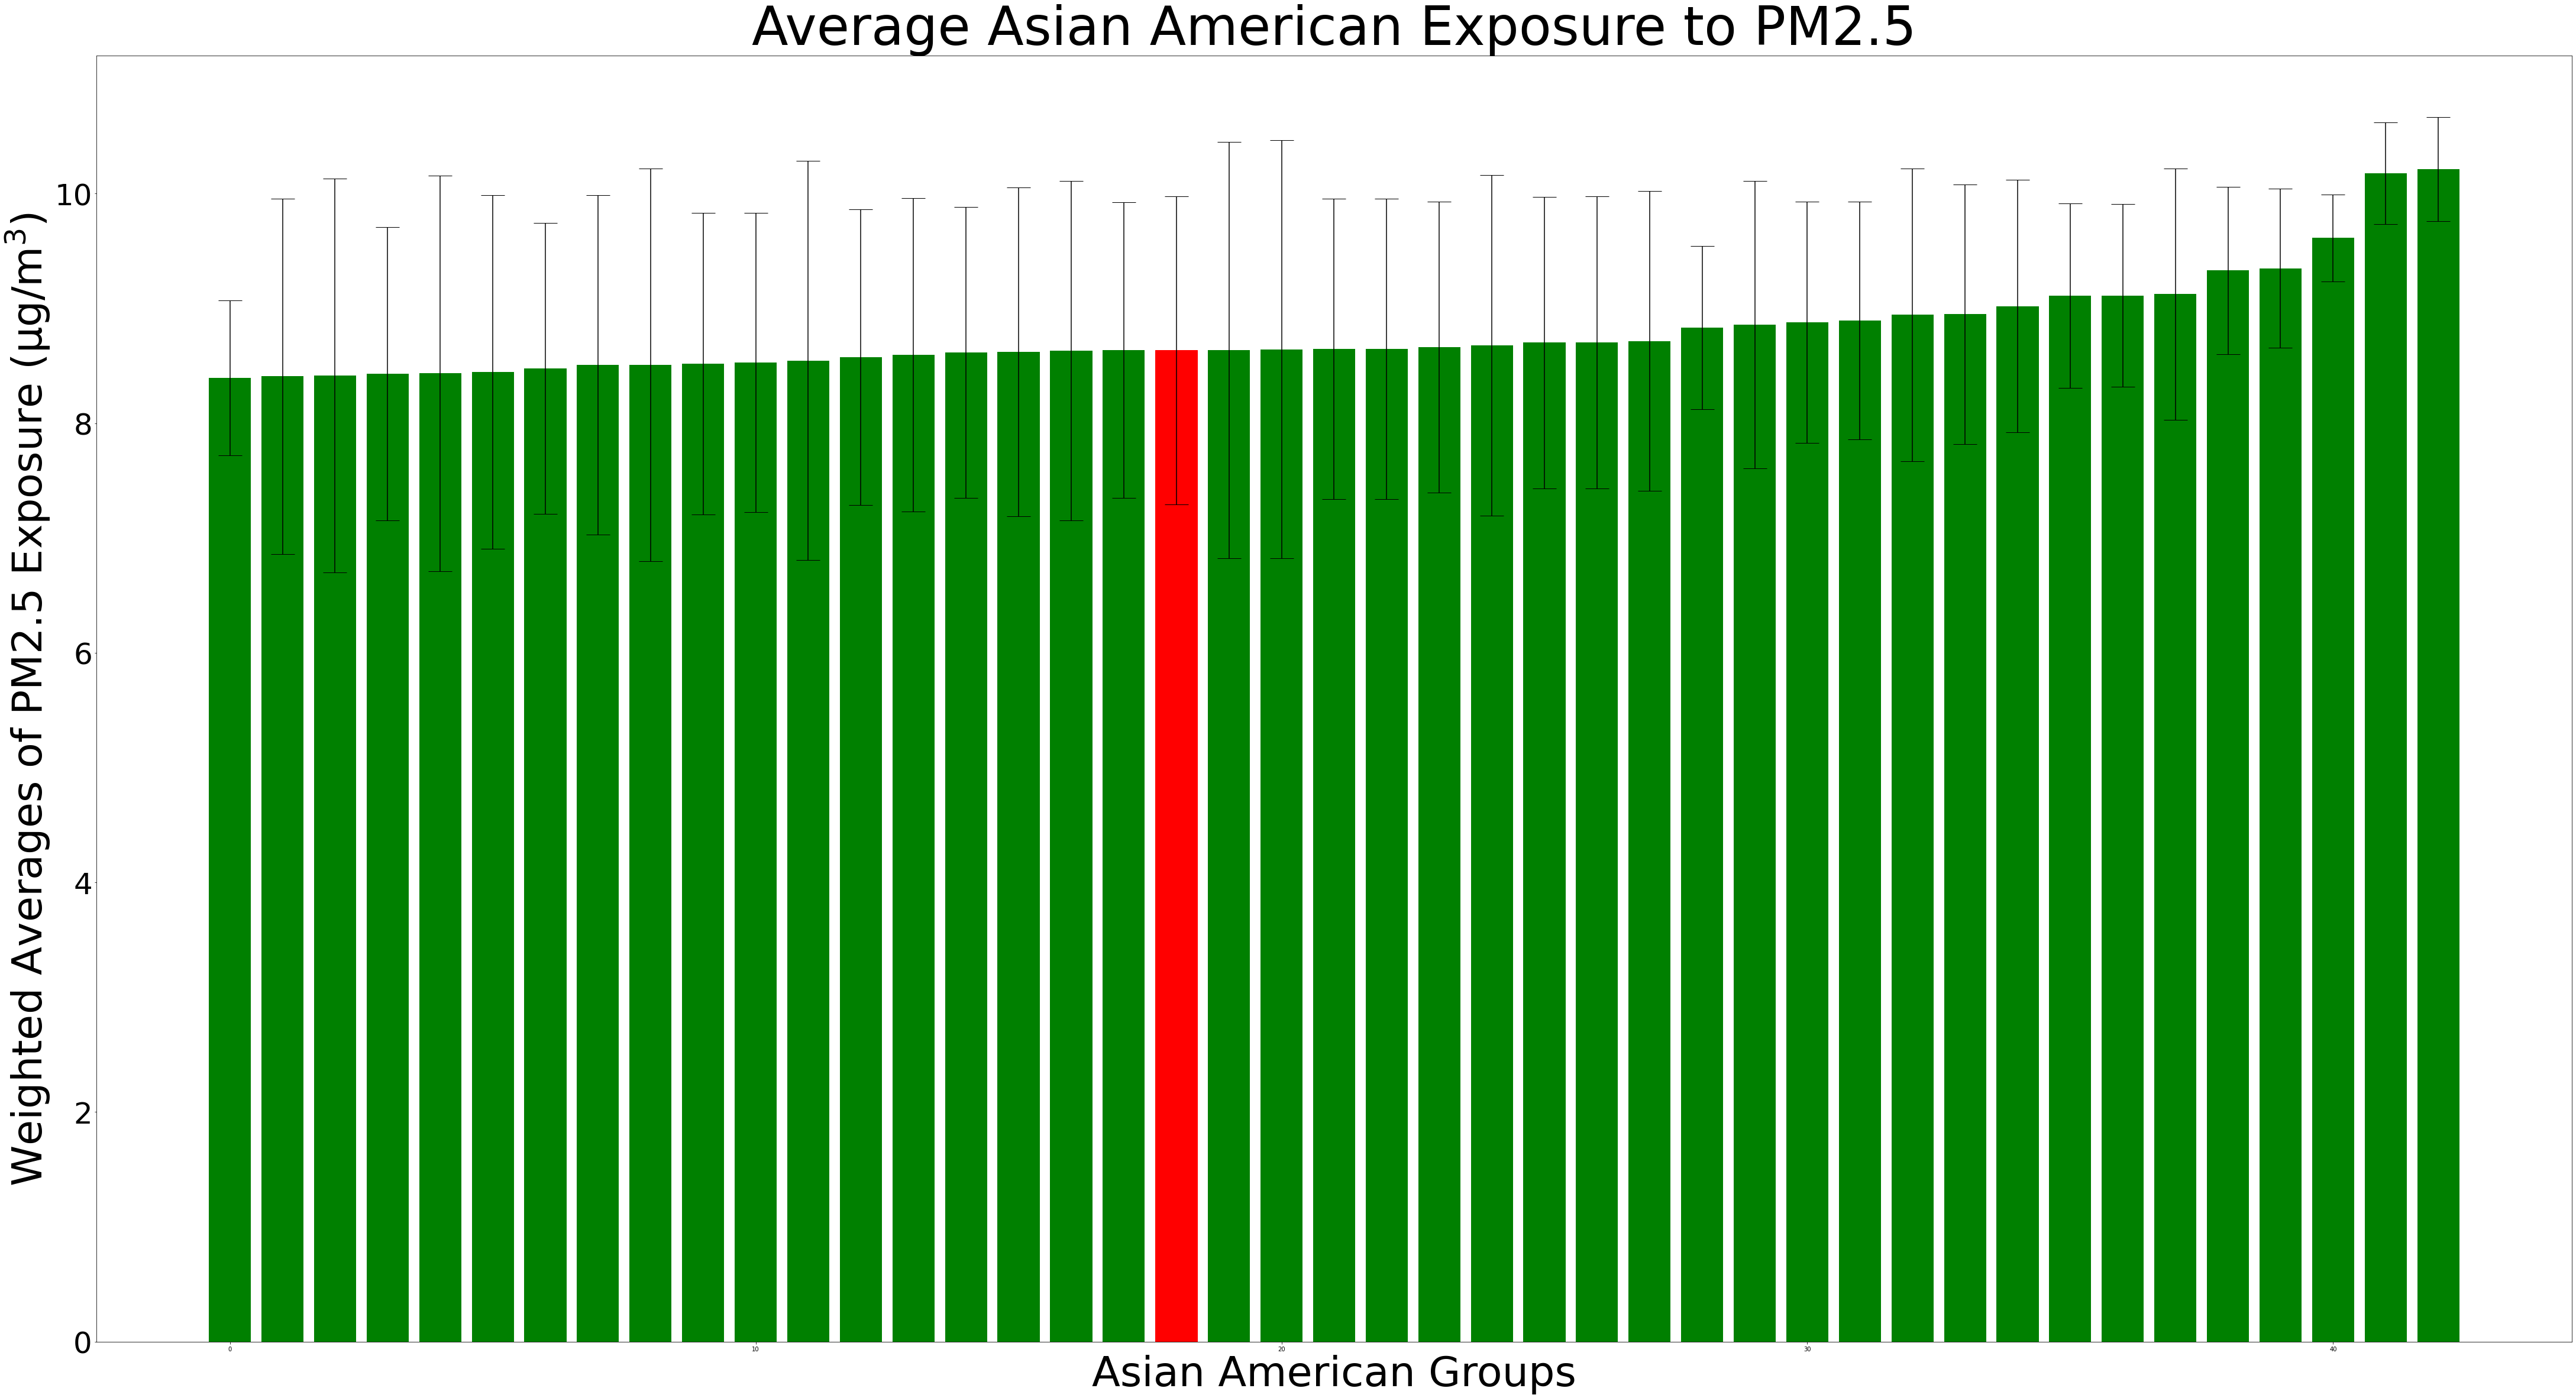

In [50]:
# Build the plot for the middle school presentation
popgroup_names = sorted_weighted_avg_df["POPGROUP_LABEL"].to_numpy()
weighted_avgs = sorted_weighted_avg_df["weighted_average"].to_numpy()
std_devs = sorted_weighted_avg_df["std_dev_parts_and_actual"].to_numpy()

x_pos = [i for i, _ in enumerate(popgroup_names)]


plt.figure(figsize=(75,40))
barlist = plt.bar(x_pos, weighted_avgs, color = "green", yerr = std_devs, capsize = 20)
barlist[18].set_color("red")
plt.ylabel("Weighted Averages of PM2.5 Exposure (μg/m$^3$)", fontsize = 70)
plt.yticks(fontsize = 50)
plt.xlabel("Asian American Groups", fontsize = 70)
plt.title("Average Asian American Exposure to PM2.5", fontsize = 90)

# plt.xticks(x_pos, fontsize = 30)

plt.show()

In [51]:
indexed_subgroup_swad = sorted_weighted_avg_df.set_index("POPGROUP_LABEL")
indexed_subgroup_swad.drop(labels = "std_dev_parts_and_actual", axis = 1, inplace = True)

In [52]:
combined_average = indexed_subgroup_swad.weighted_average["Combined Asian American Subgroups"]
combined_average

8.634442778201054

In [53]:
# calculations for anova testing

def anova_with_weighted_averages(df1, dfs, df2):
    def calculate_ssr(df1):
        df1["anova_regression_squares"] = np.square(df1["weighted_average"] - df1.weighted_average["Combined Asian American Subgroups"])
        df1["anova_SSR"] = ""
        df1.loc[df1.shape[0]] = [None, 0, None]

    def calculate_error_sum_of_squares(dfs):
        for dataset in dfs:
            dataset["anova_error_squares"] = np.square(dataset["pred_wght"] - dataset["weighted_average"].iloc[(len(dataset["weighted_average"]) - 1)]) * dataset["estimated_pop"]
    
    calculate_ssr(df1)
    SSR = df1["anova_regression_squares"].sum()
    calculate_error_sum_of_squares(dfs)
    combined_dfs = pd.concat(dfs)
    SSE = combined_dfs["anova_error_squares"].sum()
    SST = SSR + SSE
    
    plt.rcParams['figure.dpi'] = 300
    
    fig, ax = plt.subplots()
    
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    table_input = {"Source": ["Treatment", "Error", "Total"], "Sum of Squares (SS)": [SSR, SSE, SST], "df": [(len(df1["weighted_average"]) - 1) - 1, df2["estimated_pop"].iloc[-1] - (len(df1["weighted_average"]) - 1), df2["estimated_pop"].iloc[-1] - 1], "Mean Squares (MS)": [SST / ((len(df1["weighted_average"]) - 1) - 1), SSE / (df2["estimated_pop"].iloc[-1] - (len(df1["weighted_average"]) - 1)), " "], "F value": [(SST / ((len(df1["weighted_average"]) - 1) - 1)) / (SSE / (df2["estimated_pop"].iloc[-1] - (len(df1["weighted_average"]) - 1))), " ", " "]} 
    table = pd.DataFrame(data = table_input)
    
    anova_table = ax.table(cellText = table.values, colLabels = table.columns, loc = "center")
    
    anova_table.auto_set_font_size(False)
    
    anova_table.set_fontsize(6)
    
    fig.tight_layout()
    
    return anova_table

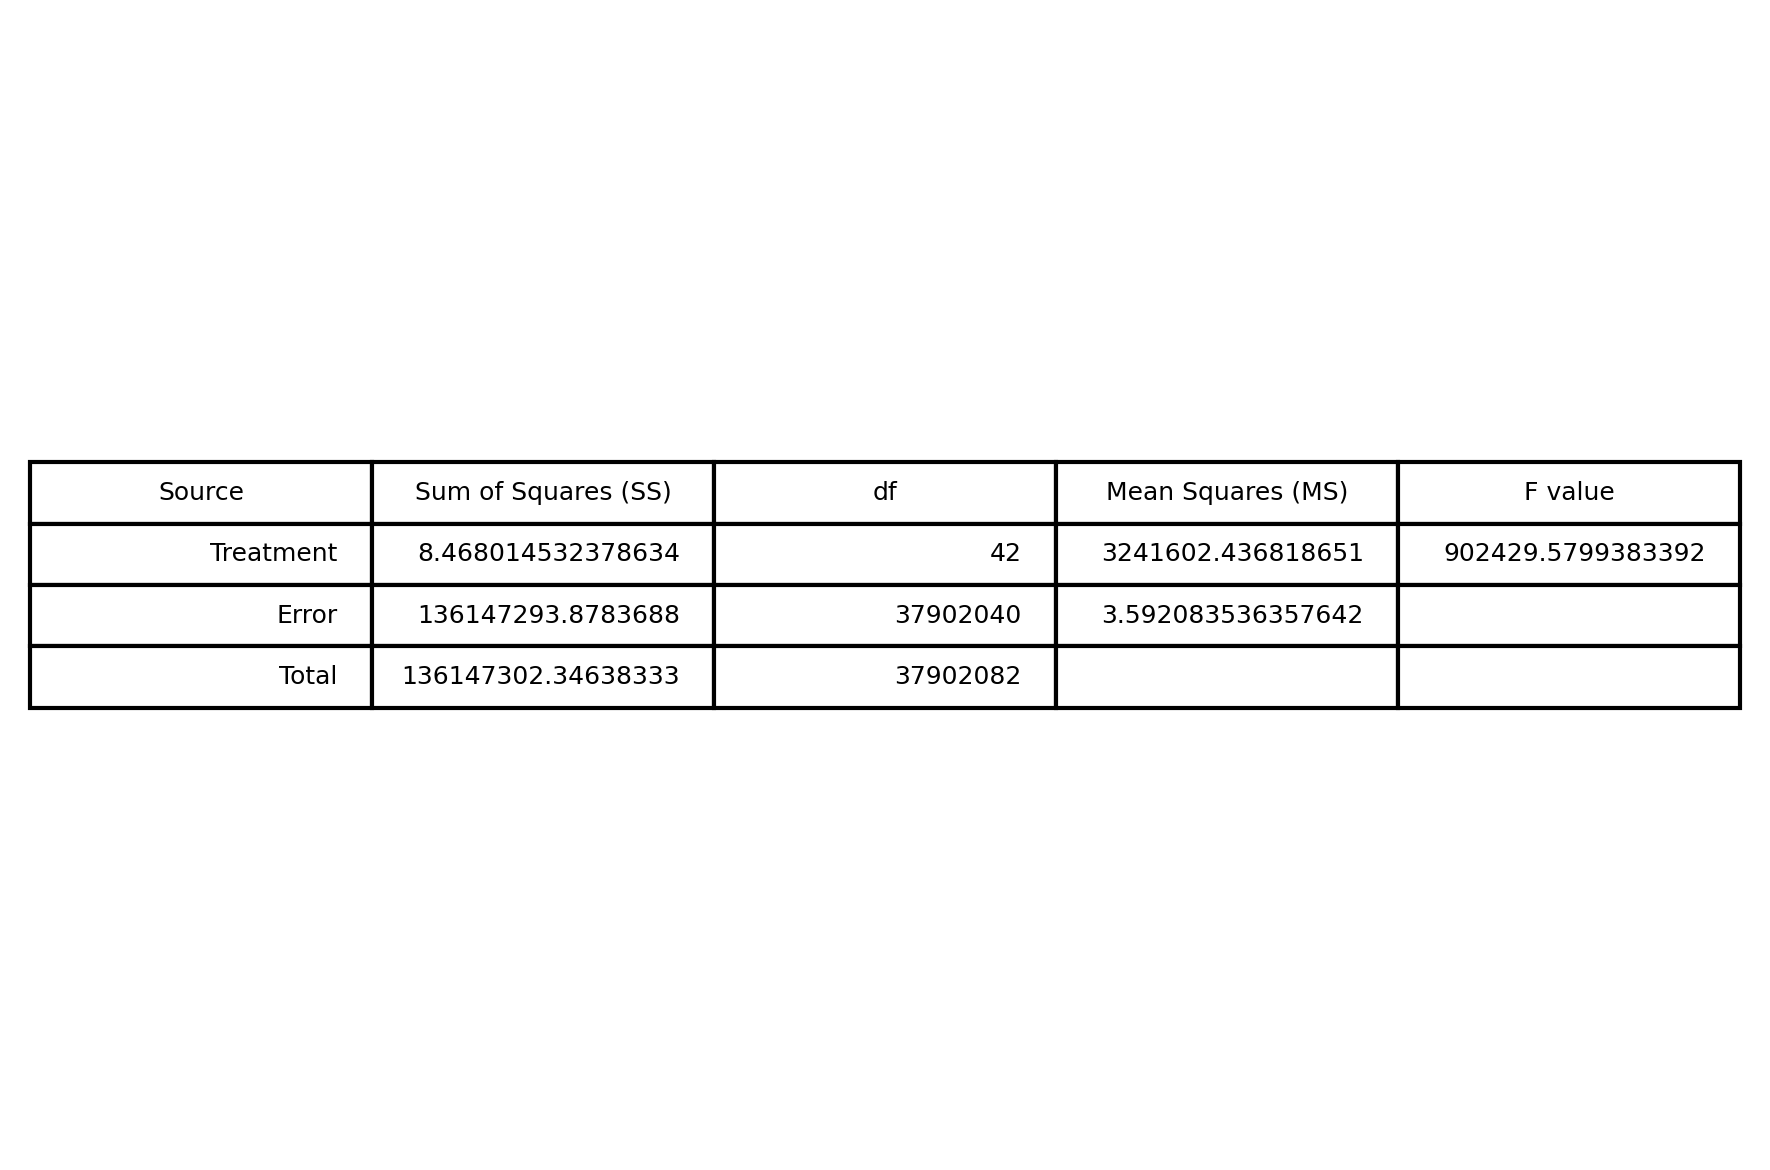

In [54]:
anova_with_weighted_averages(indexed_subgroup_swad, final_separated_datasets, combined_large_data)